c:\Users\alcheraa\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu
load
epoch : 5 Loss(train) : 1318.533  Loss(valid) : 146.776
epoch : 10 Loss(train) : 481.439  Loss(valid) : 106.709
epoch : 15 Loss(train) : 643.152  Loss(valid) : 321.948
epoch : 20 Loss(train) : 1236.391  Loss(valid) : 277.850
epoch : 25 Loss(train) : 598.990  Loss(valid) : 79.681
epoch : 30 Loss(train) : 451.974  Loss(valid) : 95.111
epoch : 35 Loss(train) : 992.705  Loss(valid) : 309.812
epoch : 40 Loss(train) : 1171.202  Loss(valid) : 395.520
epoch : 45 Loss(train) : 569.261  Loss(valid) : 294.114
epoch : 50 Loss(train) : 726.606  Loss(valid) : 197.618


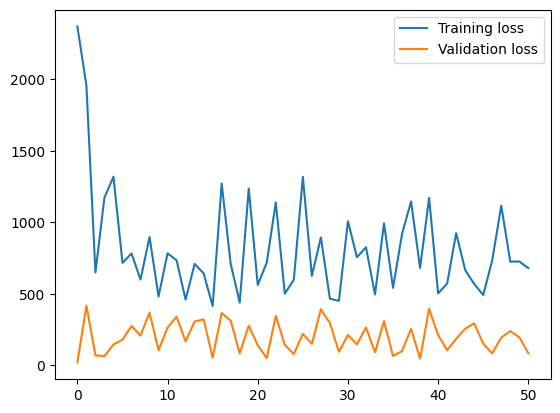

[I 2024-06-13 13:56:31,659] Trial 30 finished with value: 680.1453981399536 and parameters: {'stock_input': 8, 'index_input': 27, 'batch_size': 32, 'epoch': 51, 'learning_rate': 0.027249476823410626, 'stock_node': 64, 'index_node': 16, 'output_node': 512, 'dense_node': 27}. Best is trial 28 with value: 71.52080059051514.


Training lmmoss:  680.1453981399536
Validation loss:  85.37625789642334
epoch : 5 Loss(train) : 1162.274  Loss(valid) : 217.038
epoch : 10 Loss(train) : 725.340  Loss(valid) : 175.821
epoch : 15 Loss(train) : 1395.247  Loss(valid) : 15.611
epoch : 20 Loss(train) : 1415.763  Loss(valid) : 185.108
epoch : 25 Loss(train) : 1411.629  Loss(valid) : 74.644
epoch : 30 Loss(train) : 1826.720  Loss(valid) : 35.903
epoch : 35 Loss(train) : 708.224  Loss(valid) : 82.195
epoch : 40 Loss(train) : 1563.539  Loss(valid) : 314.566
epoch : 45 Loss(train) : 1066.726  Loss(valid) : 25.699
epoch : 50 Loss(train) : 1572.474  Loss(valid) : 152.089


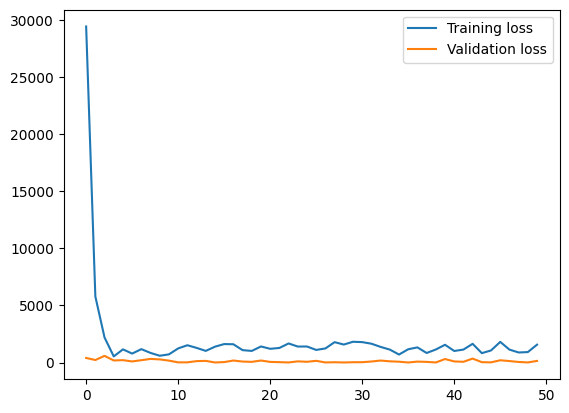

Training lmmoss:  1572.4741492271423
Validation loss:  152.088623046875
==================== best parameter ====================
71.52080059051514
==================== best parameter ====================
{'stock_input': 8, 'index_input': 27, 'batch_size': 32, 'epoch': 50, 'learning_rate': 0.09875610643495307, 'stock_node': 128, 'index_node': 32, 'output_node': 256, 'dense_node': 63}


FileNotFoundError: [Errno 2] No such file or directory: './data/AAPL.csv'

In [1]:
# package import
from models import *
from evaluate import *
from preprocessing import *

import optuna 
from optuna import Trial 
from optuna.samplers import TPESampler 

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



def objectiveLR(trial:Trial, data, device):
    params = {
        # 고정값 
        'stock_input': trial.suggest_categorical('stock_input', [8]), # (7, 9)
        'index_input': trial.suggest_categorical('index_input', [27]), # (7, 10)
        'batch_size': trial.suggest_categorical('batch_size', [32]),

        'epoch': trial.suggest_int('epoch', 50, 51),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1),
        'stock_node': trial.suggest_categorical('stock_node', [2**i for i in range(4, 10)]),
        'index_node': trial.suggest_categorical('index_node', [2**i for i in range(4, 10)]),
        'output_node': trial.suggest_categorical('output_node', [2**i for i in range(4, 10)]),

        'dense_node': trial.suggest_int('dense_node', 10, 100),
    }

    model = DualInputLSTM(device, params).to(device)
    train(model, data, params, verbose=True)
    
    return model.get_history()['Train_loss'][-1]





if __name__=="__main__":
    ############### data load & preprocessing ###############
    data = {"train": StockData(mode='train', device=device),
            "valid": StockData(mode='valid', device=device),
            "test": StockData(mode='test', device=device)}

    ############## Hyperparameter tuning with optuna ###############
    study_name = "study_pytorch_lstm"
    storage_name = f"sqlite:///pytorch_optuna/{study_name}.db"

    try:
        study = optuna.create_study(storage=storage_name,
                                    study_name=study_name,
                                    direction='minimize', 
                                    sampler=TPESampler(multivariate=True, n_startup_trials=50, seed=42))
        print("create")

    except:
        study = optuna.load_study(study_name=study_name, 
                                  storage=storage_name)
        print("load")


    study.optimize(lambda trial : objectiveLR(trial, data, device), n_trials=1)


    ############### model create & fit & evaluate ###############

    lstm = DualInputLSTM(device, study.best_params).to(device)
    train(lstm, data, study.best_params, verbose=True)
    y_test, y_pred = predict(lstm, data, study.best_params['batch_size'])


    print("="*20, "best parameter" ,"="*20)
    print(study.best_value)
    print("="*55)
    print("="*20, "best parameter" ,"="*20)
    print(study.best_params)
    print("="*55)



    if not os.path.isdir(Path(os.getcwd(), "figure")):
        os.makedirs(Path(os.getcwd(), "figure"))

    AAPL = pd.read_csv("./data/AAPL.csv")
    loss_compare(lstm.get_history())
    visualize(AAPL, y_pred)
    zoom_visualize(AAPL, y_pred)



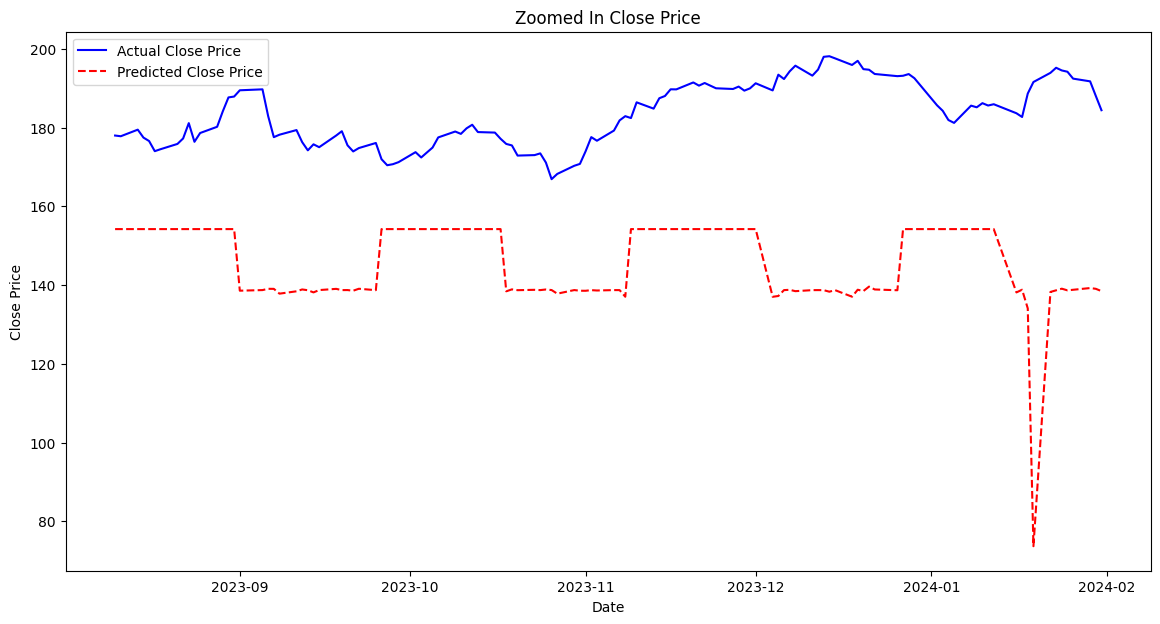

In [6]:
zoom_visualize(AAPL, y_pred)